### Business Objective
Rossmann operates over 3000 drug stores in 7 European countries. Currently, Rossmann store managers are tasked to predict their daily sales for six weeks in advance. Store sales are influenced by many factors, including promotions, competition, school and state holidays, seasonality, and locality. With thousands of individual managers predicting sales based on their unique circumstances, the accuracy of results can be quite varied.
The objective is to create a robust prediction model to help store managers to plan in advance.


The study will be conducted in below steps :
1. Exploratory Data Analysis
2. Feature Engineering
3. Building a model
4. Evaluating the result from the model
5. Conclusion

### 1. Exploratory Data Analysis
This step is to familiarize the database about the variables and clean (missing data, redundant data and outliers).

In [1]:
# Import packages

# For data manipulation
import numpy as np
import pandas as pd

# For data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# For displaying all of the columns in dataframes
pd.set_option('display.max_columns', None)

# For data modeling
from xgboost import XGBClassifier
from xgboost import XGBRegressor
from xgboost import plot_importance

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

# For metrics and helpful functions
from sklearn.model_selection import GridSearchCV, train_test_split



## Load the dataset
There are 3 files regarding this study.
1. train : input to create a model
2. store : input to create a model
3. test : to be used to test the model

In [2]:
data_train = pd.read_csv(r'C:\STUDY\Python\Portfolio Project\Sales Prediction\Dataset\train.csv')
data_store = pd.read_csv(r'C:\STUDY\Python\Portfolio Project\Sales Prediction\Dataset\store.csv')


C:\Users\User\AppData\Local\Temp\ipykernel_11776\2765746315.py:1: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  data_train = pd.read_csv(r'C:\STUDY\Python\Portfolio Project\Sales Prediction\Dataset\train.csv')


In [47]:
print(data_train.shape)
data_train.head()

(1001599, 10)


,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Id
0,1,5,2015-07-17,4852,519,1,1,0,0,303445
1,2,5,2015-07-17,4518,495,1,1,0,1,959585
2,3,5,2015-07-17,6679,673,1,1,0,1,739744
3,4,5,2015-07-17,10514,1343,1,1,0,1,864001
4,5,5,2015-07-17,4355,513,1,1,0,1,981931


There are 1,001,599 observations with 10 variables in train data.
Store - a unique ID for each store
DayOfWeek - any one of the seven days in a week : 1 = Monday, 7 = Sunday
Date - date of sales transaction
Sales - the turnover for any given day (this is to predict)
Customers - the number of customers on a given day
Open - an indicator for whether the store was open: 0 = closed, 1 = open
promo - indicates whether a store is running a promo on that day
StateHoliday - indicates a state holiday. a = public holiday, b = Easter holiday, c = Christmas, 0 = None
SchoolHoliday - indicates if the transaction date is the closure of public schoos

In [48]:
print(data_store.shape)
data_store.head()

(1115, 10)


,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


There are 1,115 stores with 10 variables in store file.
StoreType - differentiates between 4 different store models: a, b, c, d
Assortment - describes an assortment level: a = basic, b = extra, c = extended
CompetitionDistance - distance in meters to the nearest competitor store
CompetitionOpenSince[Month/Year] - gives the approximate year and month of the time the nearest competitor was opened
Promo2 - Promo2 is a continuing and consecutive promotion for some stores: 0 = store is not participating, 1 = store is participating
Promo2Since[Year/Week] - describes the year and calendar week when the store started participating in Promo2
PromoInterval - describes the consecutive intervals Promo2 is started, naming the months the promotion is started anew. E.g. "Feb,May,Aug,Nov" means each round starts in February, May, August, November of any given year for that store

## Data Merging
This is to merge train and store files in a dataframe for easy manipulation

In [80]:
data_org = data_store.merge(data_train,on=['Store'],how='inner')
data_org.shape

(1001599, 19)

## Data Cleaning
This is to check if there are any missing values in the dataset

In [50]:
data_org.isna().sum()

Store                             0
StoreType                         0
Assortment                        0
CompetitionDistance            2600
CompetitionOpenSinceMonth    318392
CompetitionOpenSinceYear     318392
Promo2                            0
Promo2SinceWeek              500415
Promo2SinceYear              500415
PromoInterval                500415
DayOfWeek                         0
Date                              0
Sales                             0
Customers                         0
Open                              0
Promo                             0
StateHoliday                      0
SchoolHoliday                     0
Id                                0
dtype: int64

We found that there are null values in Competition variables. Null in CompetitionDistance indicate that the store does not have closer competitors. Therefore, missing value will be filled out with a maximum competition distance value from the dataset.

In [81]:
data_org['CompetitionDistance'] = data_org['CompetitionDistance'].fillna(data_org['CompetitionDistance'].max())
data_org['CompetitionDistance'].isna().sum()

np.int64(0)

For rest of the missing variables will be filled with 0 because they indicate no promotion and no competitor.

In [82]:
data_org.fillna(0,inplace=True)
data_org.isna().sum()

Store                        0
StoreType                    0
Assortment                   0
CompetitionDistance          0
CompetitionOpenSinceMonth    0
CompetitionOpenSinceYear     0
Promo2                       0
Promo2SinceWeek              0
Promo2SinceYear              0
PromoInterval                0
DayOfWeek                    0
Date                         0
Sales                        0
Customers                    0
Open                         0
Promo                        0
StateHoliday                 0
SchoolHoliday                0
Id                           0
dtype: int64

In [53]:
data_org.duplicated().sum()

np.int64(0)

There are no duplicated observations.

In [54]:
data_org.dtypes

Store                          int64
StoreType                     object
Assortment                    object
CompetitionDistance          float64
CompetitionOpenSinceMonth    float64
CompetitionOpenSinceYear     float64
Promo2                         int64
Promo2SinceWeek              float64
Promo2SinceYear              float64
PromoInterval                 object
DayOfWeek                      int64
Date                          object
Sales                          int64
Customers                      int64
Open                           int64
Promo                          int64
StateHoliday                  object
SchoolHoliday                  int64
Id                             int64
dtype: object

This study is for time series analysis. Therefore we need to add more new columns regarding time period.

In [83]:
data_org['Date'] = pd.to_datetime(data_org['Date'])
data_org['Year'] = data_org['Date'].dt.year
data_org['Month'] = data_org['Date'].dt.month
data_org['Day'] = data_org['Date'].dt.day
data_org['Week'] = data_org['Date'].dt.weekday
from datetime import datetime
data_org['Year-Month'] = data_org['Date'].dt.strftime('%Y-%m')
data_org['Year-Week']=data_org['Date'].dt.strftime('%Y-%w')

data_org.head()

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Id,Year,Month,Day,Week,Year-Month,Year-Week
0,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0,5,2015-07-17,4852,519,1,1,0,0,303445,2015,7,17,4,2015-07,2015-5
1,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0,4,2015-07-16,4427,517,1,1,0,0,324709,2015,7,16,3,2015-07,2015-4
2,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0,3,2015-07-15,4767,550,1,1,0,0,64663,2015,7,15,2,2015-07,2015-3
3,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0,2,2015-07-14,5042,544,1,1,0,0,704685,2015,7,14,1,2015-07,2015-2
4,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0,1,2015-07-13,5054,553,1,1,0,0,308477,2015,7,13,0,2015-07,2015-1


The study objective is to predict Sales. Therefore, we will find if there is any correlation between Sales and numerical variables first.

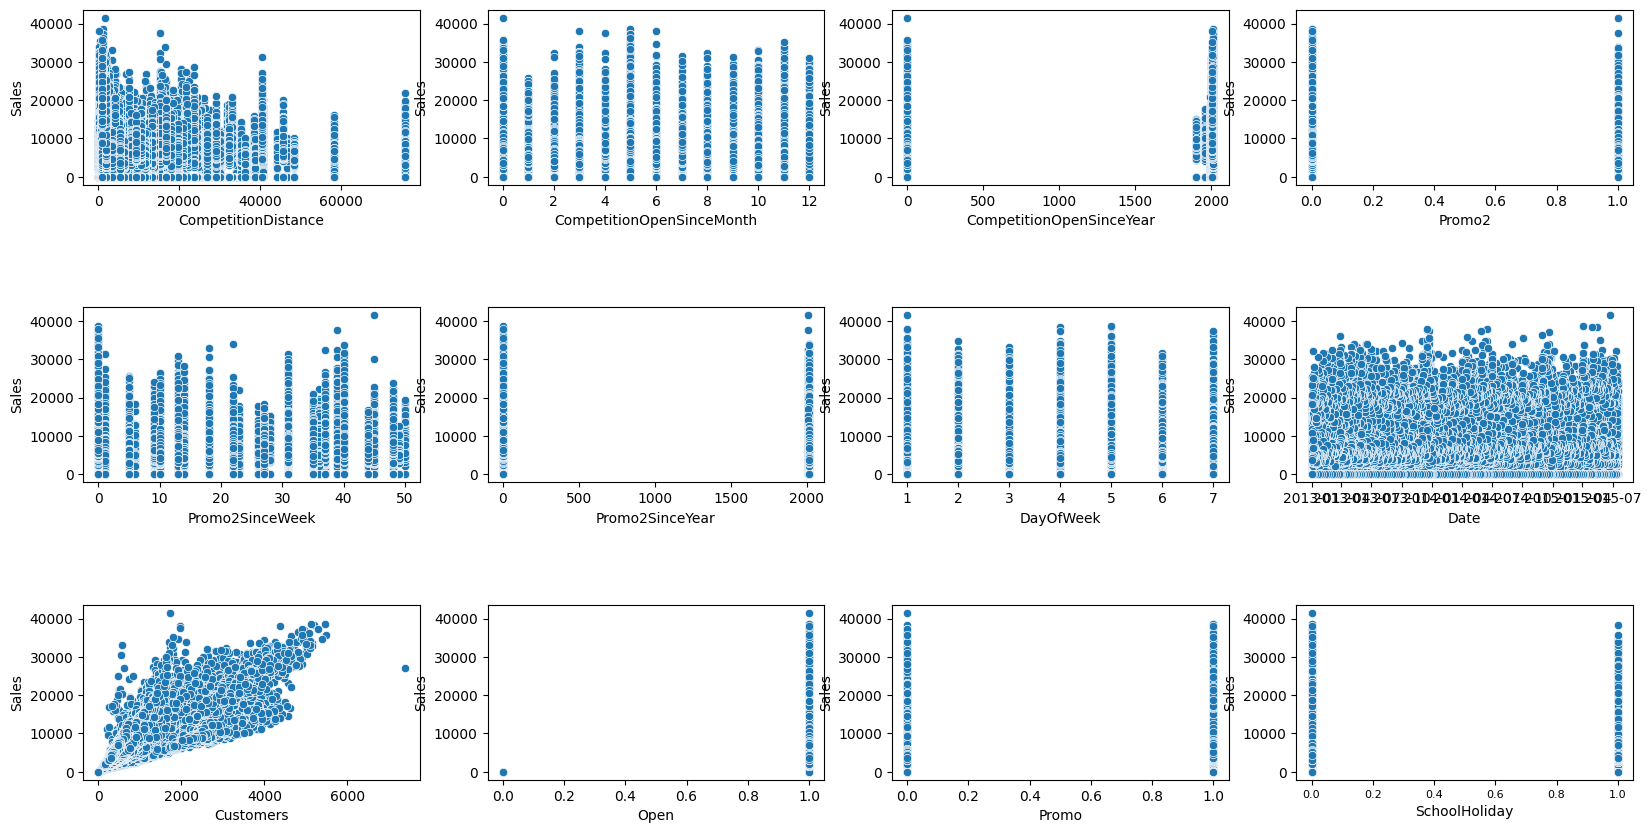

In [56]:
var_numerical = ['CompetitionDistance','CompetitionOpenSinceMonth','CompetitionOpenSinceYear','Promo2','Promo2SinceWeek','Promo2SinceYear','DayOfWeek','Date','Customers','Open','Promo','SchoolHoliday']
fig, ax = plt.subplots(3,4,figsize=(20,10))
i,j = 0,0
for var in var_numerical :
    sns.scatterplot(data=data_org,x=var,y='Sales',ax=ax[i,j])
        #ax[i][j].tick_params(axis='x', rotation=90)
    j += 1
    if j == 4 :
        j = 0
        i += 1

plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.7)
plt.xticks(fontsize=8)
plt.show()

According to preceeding plot, it seems that there is positive correleation between Sales and Customers variable. It makes sense because the store will make more sales if there are more customers. The other visuals do not indicate any significance. But we will do multi-varirate analysis later.

This is to check categorical varibles and Sales variable.

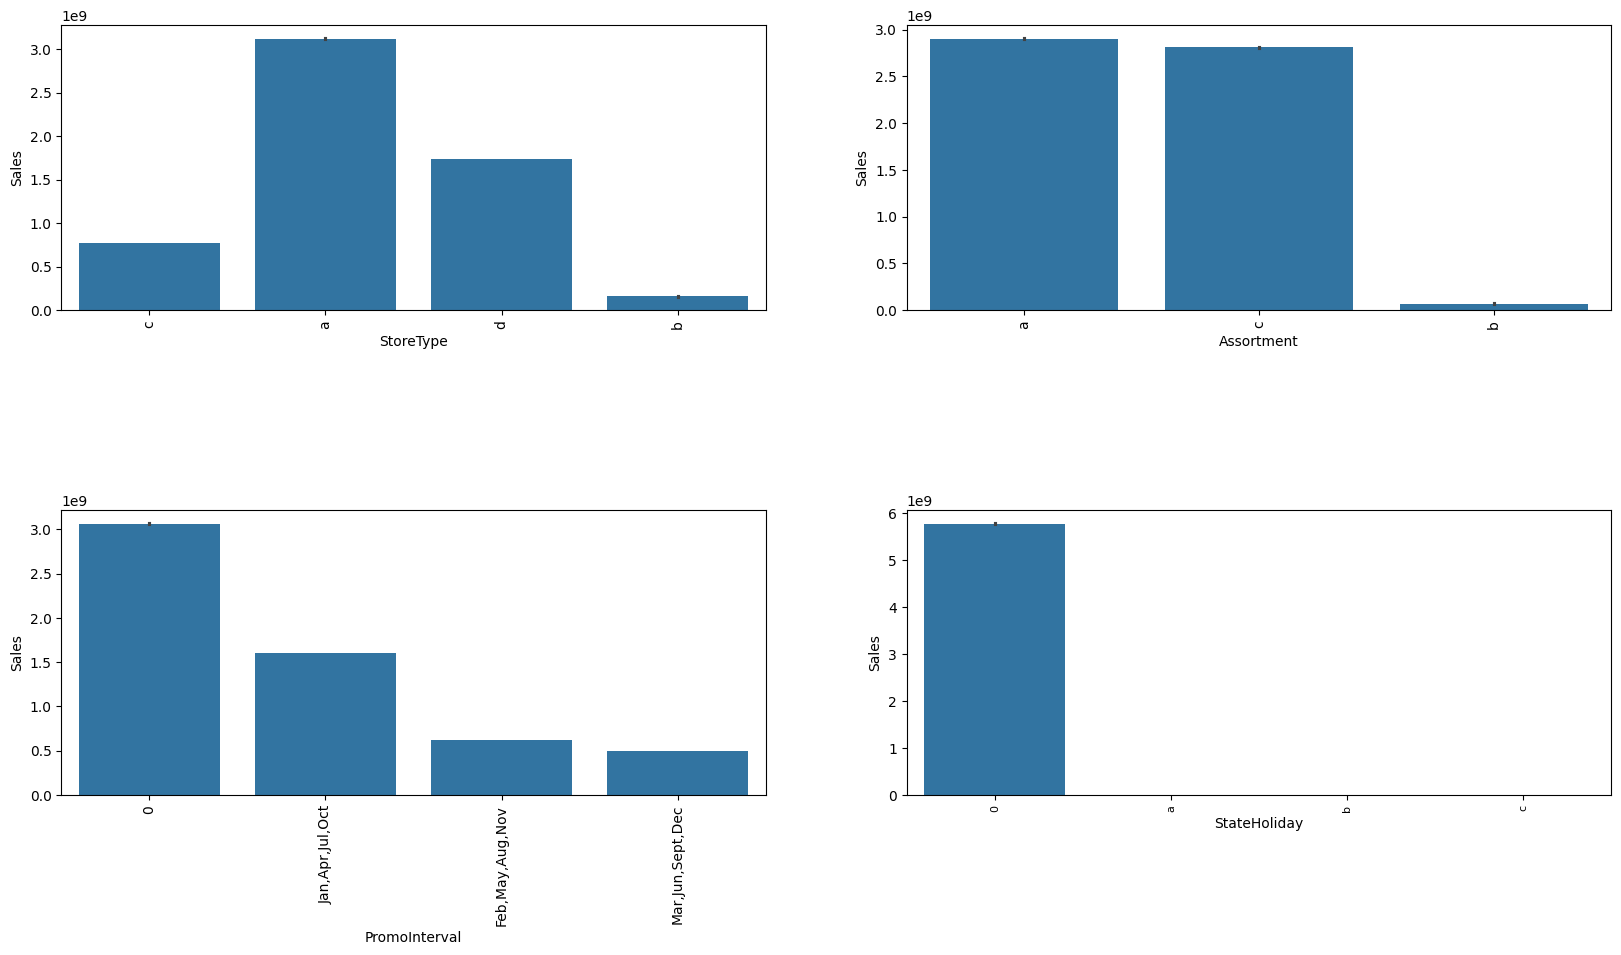

In [57]:
var_categorical = ['StoreType','Assortment','PromoInterval','StateHoliday']
fig, ax = plt.subplots(2,2,figsize=(20,10))
i,j = 0,0
for var in var_categorical :
    sns.barplot(data=data_org,x=var,y='Sales',estimator=sum,ax=ax[i,j])
    #sns.barplot(data=data_org,x=var,color='Attrition',ax=ax[i,j])
    ax[i][j].tick_params(axis='x', rotation=90)
    j += 1
    if j == 2 :
        j = 0
        i += 1

plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.7)
plt.xticks(fontsize=8)
plt.show()

Given the visuals, below are the finding :
1. Store type a and d has more sales
2. Assortment a and c has more sales
3. Jan,Apr,Jul,Oct promotion interval has more sales


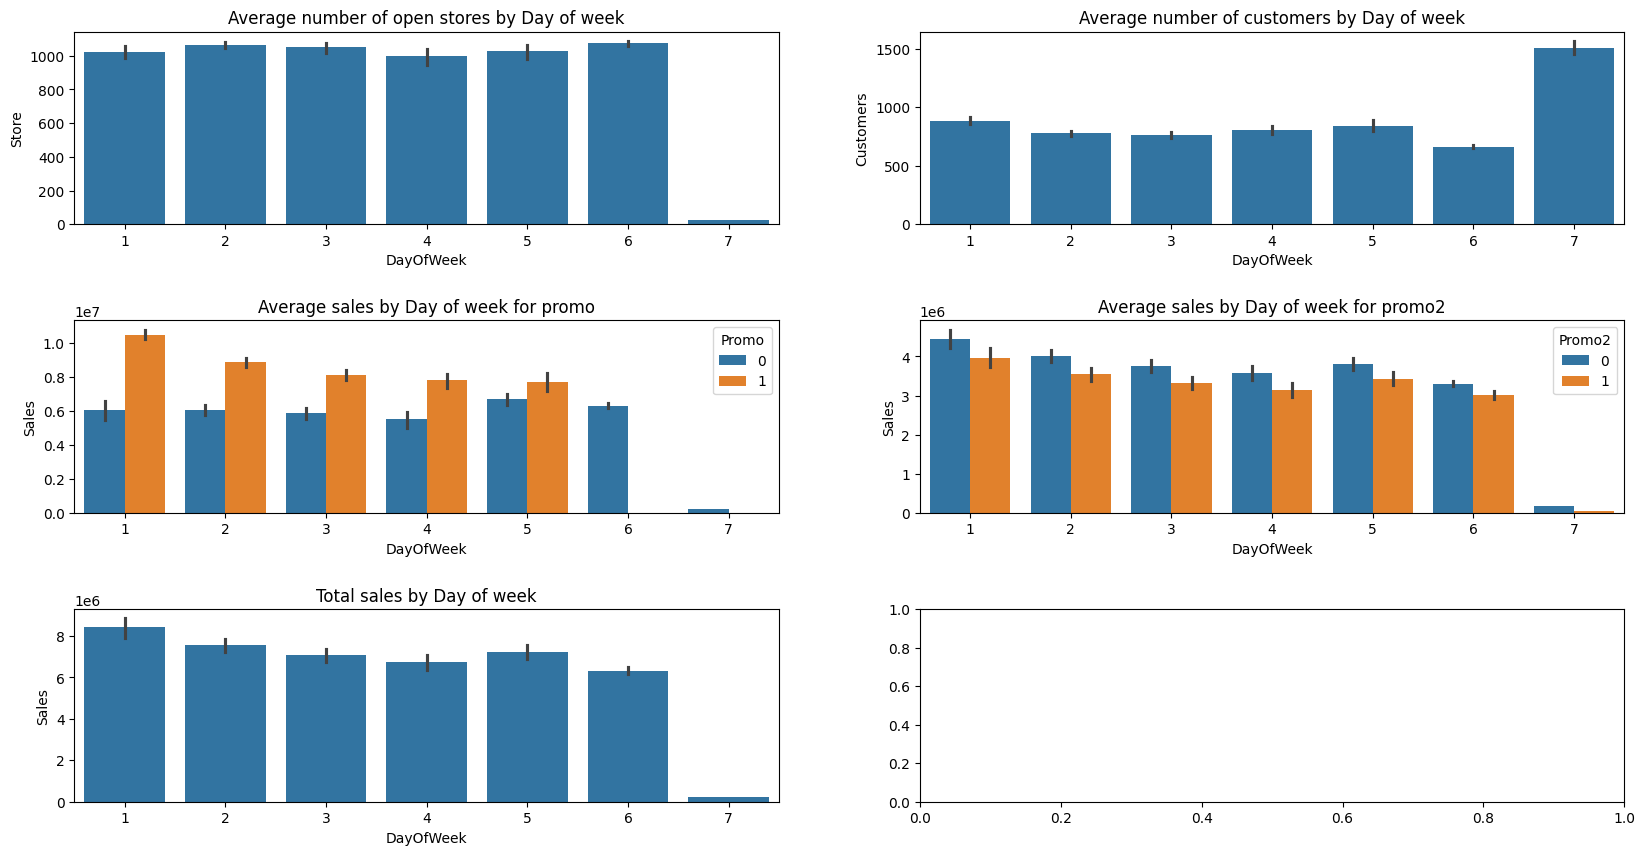

In [58]:
fig, ax = plt.subplots(3,2,figsize=(20,10))

data_vis1 = (data_org[data_org['Open']==1].groupby(['DayOfWeek','Year','Month','Day'])['Store'].count()).reset_index()
sns.barplot(data=data_vis1,x='DayOfWeek',y='Store',ax=ax[0,0])
ax[0,0].set(title='Average number of open stores by Day of week')

data_vis2 = (data_org[data_org['Open']==1].groupby(['DayOfWeek','Year','Month','Day'])['Customers'].mean()).reset_index()
sns.barplot(data=data_vis2,x='DayOfWeek',y='Customers',ax=ax[0,1])
ax[0,1].set(title='Average number of customers by Day of week')

data_vis3 = (data_org.groupby(['DayOfWeek','Year','Month','Day','Promo'])['Sales'].sum()).reset_index()
sns.barplot(data=data_vis3,x='DayOfWeek',y='Sales',hue='Promo',ax=ax[1,0])
ax[1,0].set(title='Average sales by Day of week for promo')

data_vis4 = (data_org.groupby(['DayOfWeek','Year','Month','Day','Promo2'])['Sales'].sum()).reset_index()
sns.barplot(data=data_vis4,x='DayOfWeek',y='Sales',hue='Promo2',ax=ax[1,1])
ax[1,1].set(title='Average sales by Day of week for promo2')

data_vis5 = (data_org.groupby(['DayOfWeek','Year','Month','Day','Promo'])['Sales'].sum()).reset_index()
sns.barplot(data=data_vis5,x='DayOfWeek',y='Sales',ax=ax[2,0])
ax[2,0].set(title='Total sales by Day of week')


plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.5)



Most of the stores are closed in Sunday. And there is no promotion at weekend. Therefore, sales in Sunday is significantly smaller than the rest of the days. 
In general, Monday has highest sales in a week. But without promotion, Friday has the highest and Monday has the highest with promotion.

[Text(0.5, 1.0, 'Number of customers by competition distance')]

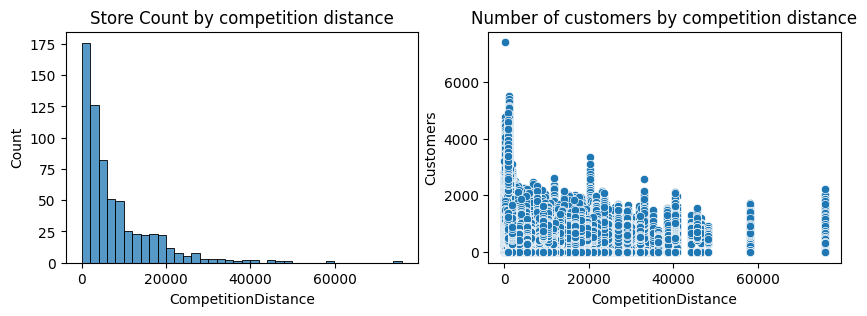

In [59]:
fig,ax = plt.subplots(1,2,figsize=(10,3))

data_vis6 = (data_org.groupby('CompetitionDistance')['Store'].count()).reset_index()
sns.histplot(data=data_vis6,x='CompetitionDistance',ax=ax[0])
ax[0].set(title='Store Count by competition distance')

sns.scatterplot(data=data_org,x='CompetitionDistance',y='Customers',ax=ax[1])
ax[1].set(title='Number of customers by competition distance')



Most of the stores are in 20,000 meter of distance with competitors.

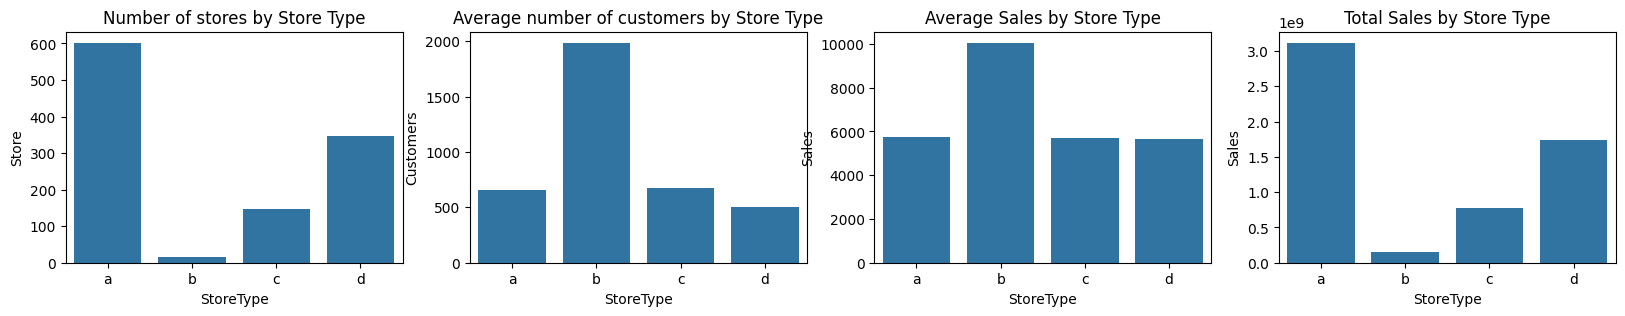

In [60]:
fig,ax = plt.subplots(1,4,figsize=(20,3))

data_vis7 = (data_org.groupby('StoreType')['Store'].nunique()).reset_index()
sns.barplot(data=data_vis7,x='StoreType',y='Store',ax=ax[0])
ax[0].set(title='Number of stores by Store Type')

data_vis8 = (data_org.groupby('StoreType')['Customers'].mean()).reset_index()
sns.barplot(data=data_vis8,x='StoreType',y='Customers',ax=ax[1])
ax[1].set(title='Average number of customers by Store Type')

data_vis9 = (data_org.groupby('StoreType')['Sales'].mean()).reset_index()
sns.barplot(data=data_vis9,x='StoreType',y='Sales',ax=ax[2])
ax[2].set(title='Average Sales by Store Type')

data_vis10 = (data_org.groupby('StoreType')['Sales'].sum()).reset_index()
sns.barplot(data=data_vis10,x='StoreType',y='Sales',ax=ax[3])
ax[3].set(title='Total Sales by Store Type')



plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.5)

Store type 'a' has more sales than others because it has high number of stores.

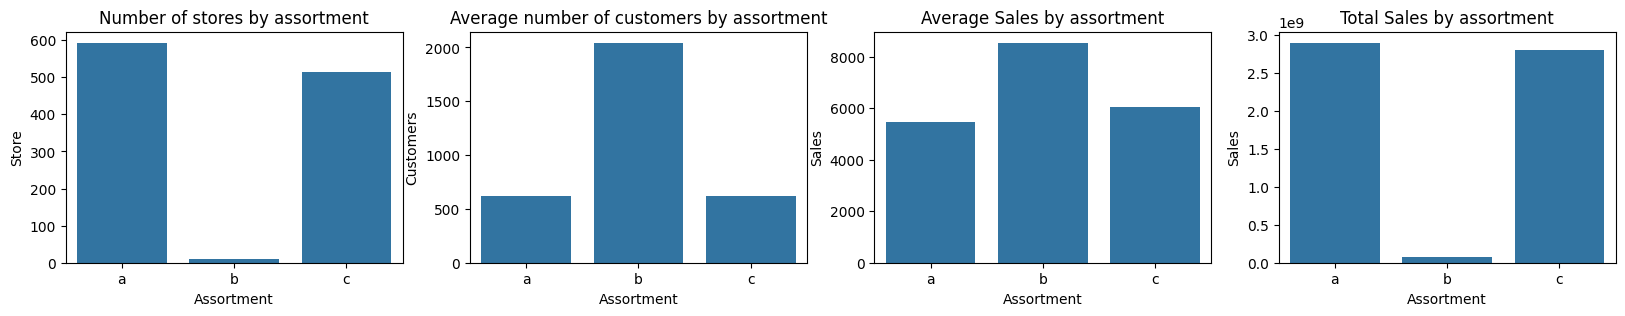

In [61]:
fig,ax = plt.subplots(1,4,figsize=(20,3))

data_vis11 = (data_org.groupby('Assortment')['Store'].nunique()).reset_index()
sns.barplot(data=data_vis11,x='Assortment',y='Store',ax=ax[0])
ax[0].set(title='Number of stores by assortment')

data_vis12 = (data_org.groupby('Assortment')['Customers'].mean()).reset_index()
sns.barplot(data=data_vis12,x='Assortment',y='Customers',ax=ax[1])
ax[1].set(title='Average number of customers by assortment')

data_vis13 = (data_org.groupby('Assortment')['Sales'].mean()).reset_index()
sns.barplot(data=data_vis13,x='Assortment',y='Sales',ax=ax[2])
ax[2].set(title='Average Sales by assortment')

data_vis14 = (data_org.groupby('Assortment')['Sales'].sum()).reset_index()
sns.barplot(data=data_vis14,x='Assortment',y='Sales',ax=ax[3])
ax[3].set(title='Total Sales by assortment')



plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.5)

Assortment b has low sale because of low number of stores.

In [62]:
data_org[data_org['SchoolHoliday']==1].groupby('Month')['Store'].nunique()

Month
1     1115
2      489
3     1115
4     1115
5      963
6      852
7     1115
8     1115
9      889
10    1115
11     419
12    1115
Name: Store, dtype: int64

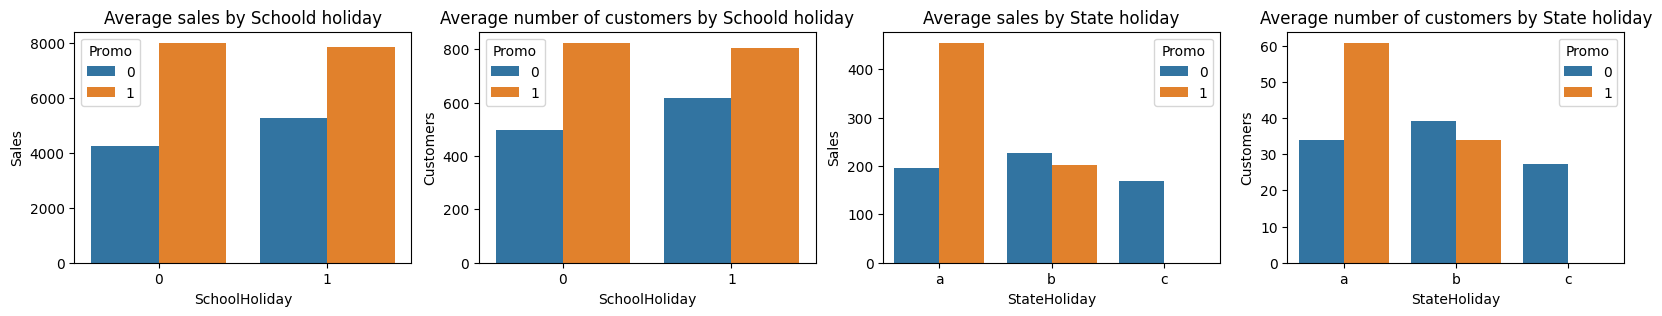

In [63]:
fig,ax = plt.subplots(1,4,figsize=(20,3))

data_vis15= data_org.groupby(['SchoolHoliday','Promo'])['Sales'].mean().reset_index()
sns.barplot(data=data_vis15,x='SchoolHoliday',y='Sales',hue='Promo',ax=ax[0])
ax[0].set(title='Average sales by Schoold holiday')

data_vis16= data_org.groupby(['SchoolHoliday','Promo'])['Customers'].mean().reset_index()
sns.barplot(data=data_vis16,x='SchoolHoliday',y='Customers',hue='Promo',ax=ax[1])
ax[1].set(title='Average number of customers by Schoold holiday')

data_vis17 = (data_org[(data_org['StateHoliday'] =='a') | (data_org['StateHoliday'] =='b') |(data_org['StateHoliday'] =='c') ]).groupby(['StateHoliday','Promo'])['Sales'].mean().reset_index()
sns.barplot(data=data_vis17,x='StateHoliday',hue='Promo',y='Sales',ax=ax[2])
ax[2].set(title='Average sales by State holiday')

data_vis18 = (data_org[(data_org['StateHoliday'] =='a') | (data_org['StateHoliday'] =='b') |(data_org['StateHoliday'] =='c') ]).groupby(['StateHoliday','Promo'])['Customers'].mean().reset_index()
sns.barplot(data=data_vis18,x='StateHoliday',y='Customers',hue='Promo',ax=ax[3])
ax[3].set(title='Average number of customers by State holiday')


plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.5)

Average sales and average number of customers increase in School holiday and also State holiday. There is no promotion in Christmas holidays.

# Correlation analysis


<Axes: >

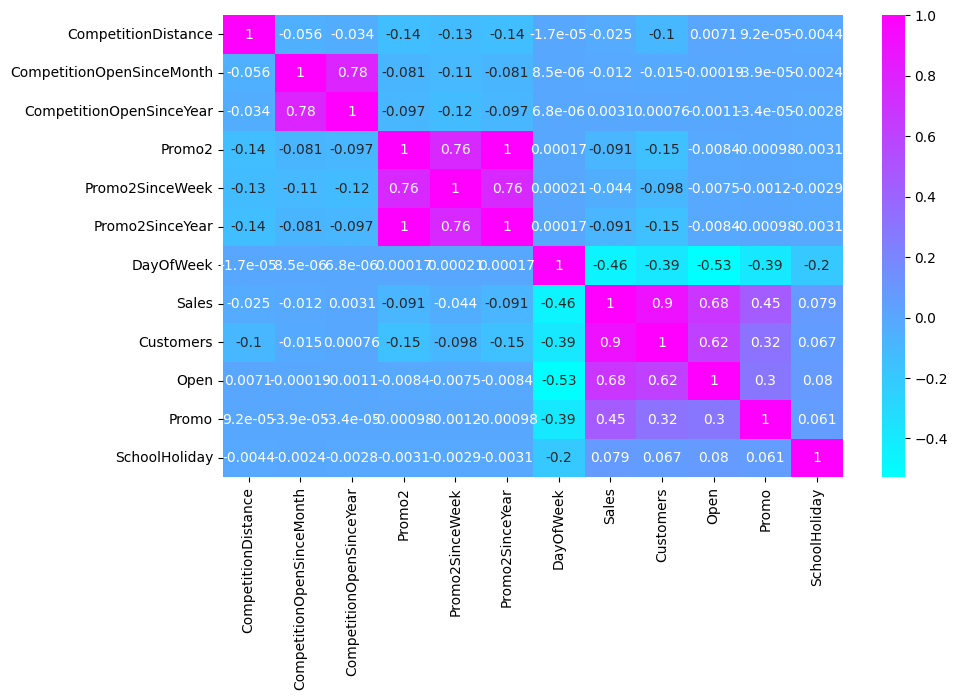

In [64]:
plt.figure(figsize=(10, 6))
data_corr = data_org[['CompetitionDistance','CompetitionOpenSinceMonth','CompetitionOpenSinceYear','Promo2','Promo2SinceWeek','Promo2SinceYear','DayOfWeek','Sales','Customers','Open','Promo','SchoolHoliday']].corr()
sns.heatmap(data_corr,annot=True,cmap='cool')

As per the preceeding correlation matrix, there is strong positive corrletaion between Sales and Customers with (0.9). And (0.68) in Sales and Open, (0.45) in Sales and Promo. 
There is negative corrlation (-0.46) in Sales and DayOfWeek because sales decrease end of the week. It happens due to most of the stores closed on Sunday.

# Handling Outliers
We will create box plot to check the outliers

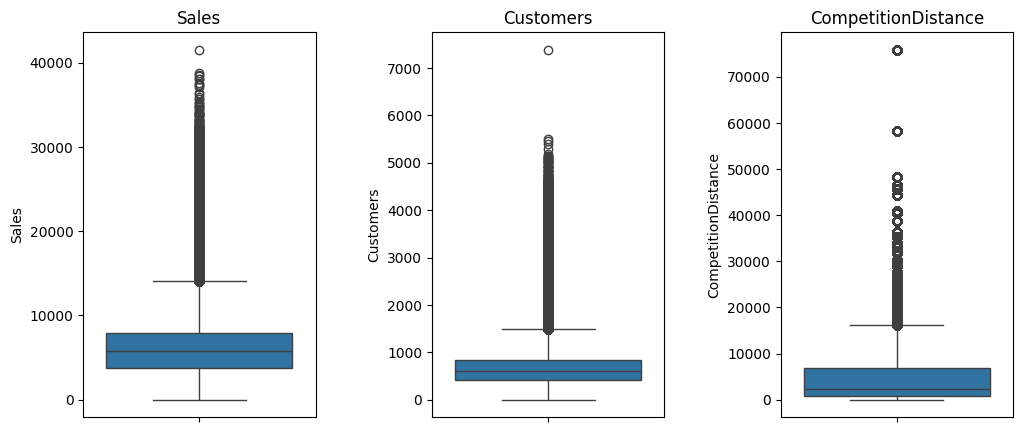

In [84]:
fig,ax = plt.subplots(1,3,figsize=(12,5))
sns.boxplot(data=data_org,y='Sales',ax=ax[0])
ax[0].set(title='Sales')

sns.boxplot(data=data_org,y='Customers',ax=ax[1])
ax[1].set(title='Customers')

sns.boxplot(data=data_org,y='CompetitionDistance',ax=ax[2])
ax[2].set(title='CompetitionDistance')

plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.5, hspace=None)

There are upper outliers. So we will calculate IQR to define outliers for each variable. And then the upper outliers will be replaced with upper bound value.

In [85]:
Q1_Sales = data_org['Sales'].quantile(0.25)
Q3_Sales = data_org['Sales'].quantile(0.75)
IQR_Sales = Q3_Sales - Q1_Sales
UpperB_Sales = Q3_Sales + IQR_Sales * 1.5
data_org.loc[data_org['Sales'] > UpperB_Sales, 'Sales'] = UpperB_Sales
#data_org['Sales'] = data_org['Sales'].replace(data_org['Sales'] > UpperB_Sales, UpperB_Sales, inplace=True)

Q1_Customers = data_org['Customers'].quantile(0.25)
Q3_Customers = data_org['Customers'].quantile(0.75)
IQR_Customers = Q3_Customers - Q1_Customers
UpperB_Customers = Q3_Customers + IQR_Customers * 1.5
data_org.loc[data_org['Customers'] > UpperB_Customers, 'Customers'] = UpperB_Customers

Q1_CompetitionDistance = data_org['CompetitionDistance'].quantile(0.25)
Q3_CompetitionDistance = data_org['CompetitionDistance'].quantile(0.75)
IQR_CompetitionDistance = Q3_CompetitionDistance - Q1_CompetitionDistance
UpperB_CompetitionDistance = Q3_CompetitionDistance + IQR_CompetitionDistance * 1.5
data_org.loc[data_org['CompetitionDistance'] > UpperB_CompetitionDistance, 'CompetitionDistance'] = UpperB_CompetitionDistance

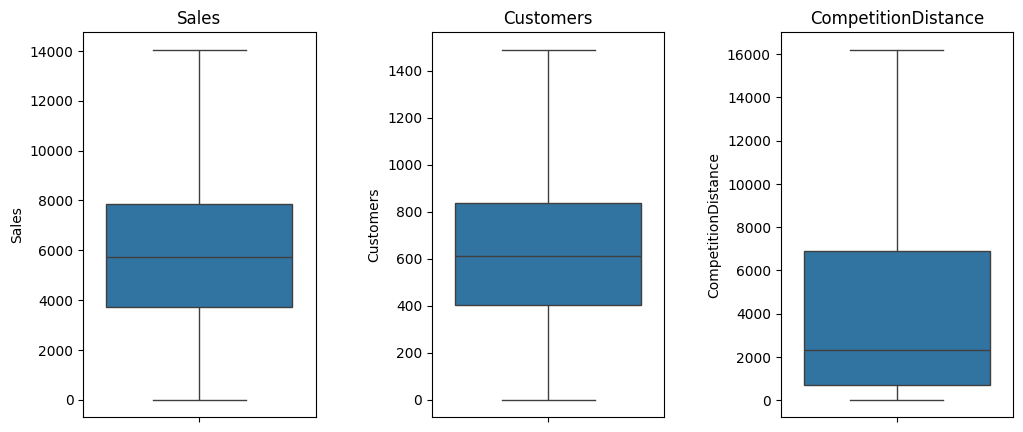

In [86]:
fig,ax = plt.subplots(1,3,figsize=(12,5))
sns.boxplot(data=data_org,y='Sales',ax=ax[0])
ax[0].set(title='Sales')

sns.boxplot(data=data_org,y='Customers',ax=ax[1])
ax[1].set(title='Customers')

sns.boxplot(data=data_org,y='CompetitionDistance',ax=ax[2])
ax[2].set(title='CompetitionDistance')

plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.5, hspace=None)

### Feature Engineering
Before working on the model, we need to encode the non-numerical variables because machine learning algorithm can only have numerical values as their predictor variables . 

In [68]:
data_org.dtypes

Store                                 int64
StoreType                            object
Assortment                           object
CompetitionDistance                 float64
CompetitionOpenSinceMonth           float64
CompetitionOpenSinceYear            float64
Promo2                                int64
Promo2SinceWeek                     float64
Promo2SinceYear                     float64
PromoInterval                        object
DayOfWeek                             int64
Date                         datetime64[ns]
Sales                                 int64
Customers                             int64
Open                                  int64
Promo                                 int64
StateHoliday                         object
SchoolHoliday                         int64
Id                                    int64
Year                                  int32
Month                                 int32
Day                                   int32
Week                            

In [152]:
# to remove redundant variables
data_enc = data_org.copy()
data_enc.drop(['Year-Month','Year-Week'],axis='columns',inplace=True)

# one-hot encoding
#data_enc = pd.get_dummies(data_enc,dtype=int,drop_first=False)

# label encoding
label_encoder = preprocessing.LabelEncoder()
data_enc['StateHoliday'] = str(data_enc['StateHoliday'])
data_enc['StateHoliday']= label_encoder.fit_transform(data_enc['StateHoliday'])
data_enc['PromoInterval'] =str(data_enc['PromoInterval'])
data_enc['PromoInterval'] =label_encoder.fit_transform(data_enc['PromoInterval'])
data_enc['Assortment'] = str(data_enc['Assortment'])
data_enc['Assortment']=label_encoder.fit_transform(data_enc['Assortment'])
data_enc['StoreType'] = str(data_enc['StoreType'])
data_enc['StoreType']=label_encoder.fit_transform(data_enc['StoreType'])

# most of the stores have competitor in  <= 20,000 distance
#data_enc['CompetitionDistance'] = data_enc['CompetitionDistance'].apply(lambda x:1 if x<=20000 else 0)

data_enc.head()
data_enc.shape

(1001599, 23)

### Building model

In [138]:
#import required libraries
from sklearn.model_selection import train_test_split 
from sklearn import preprocessing
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns

In [153]:
# train and test set split (80% of dataset will be train set and the rest 20% will be test set)
X_train = data_enc[:int(data_enc.shape[0]*80/100)].drop(columns=['Date','CompetitionOpenSinceMonth','CompetitionOpenSinceYear','Promo2SinceWeek','Promo2SinceYear','Id','Store','Sales'])
Y_train = data_enc[:int(data_enc.shape[0]*80/100)]['Sales']
X_test = data_enc[int(data_enc.shape[0]*80/100):].drop(columns=['Date','CompetitionOpenSinceMonth','CompetitionOpenSinceYear','Promo2SinceWeek','Promo2SinceYear','Id','Store','Sales'])
Y_test = data_enc[int(data_enc.shape[0]*80/100):]['Sales']

In [154]:
print(X_train.shape,Y_train.shape,X_test.shape,Y_test.shape)

(801279, 15) (801279,) (200320, 15) (200320,)


In [127]:
# Model will be evaluated by RMSPE (Root Mean Square Percentage Error)
def rmspe(y_actual,y_pred) :

    # ensure both have the same length
    assert len(y_actual) == len(y_pred)

    # percentage error
    per_error = (y_actual - y_pred)/y_actual

    # Exclude observations where true value is zero
    per_error[y_actual == 0] = 0

    # square the percentage error
    sq_per_error = per_error ** 2

    # mean of squared percentage error
    m_sq_per_error = np.mean(sq_per_error)

    # square root of mean squared perecentage error
    rmspe = np.sqrt(m_sq_per_error)

    return rmspe

In [120]:
# To automate model fitting and evaluate rmspe
def model_fit(model) :
    model.fit(X_train,Y_train)
    Y_pred = model.predict(X_test)
    train_rmspe = np.round(rmspe(Y_test,Y_pred),3)
    
    print('\n')
    print(f"RMSPE : {train_rmspe}")
    print('\n')

    # comparison of prediction with actual
    data_pred=pd.DataFrame({'Predictions':Y_pred,'Actual':Y_test})
    data_pred=data_pred.reset_index(drop=True)
    print(data_pred.head())
    print('\n')

    # comparison figure for prediction with actual
    plt.figure(figsize=(20,5))
    data_pred["Actual"][:200,].plot.line()
    data_pred["Predictions"][:200,].plot.line()
    plt.legend()
    plt.show()

    return model

### Linear Regression to predict Sales

Linear Regression Model


RMSPE : 0.2


    Predictions  Actual
0   -303.104660       0
1   7066.948483    5890
2   8720.429028    7625
3   8855.162415    8010
4  10018.972734    8756




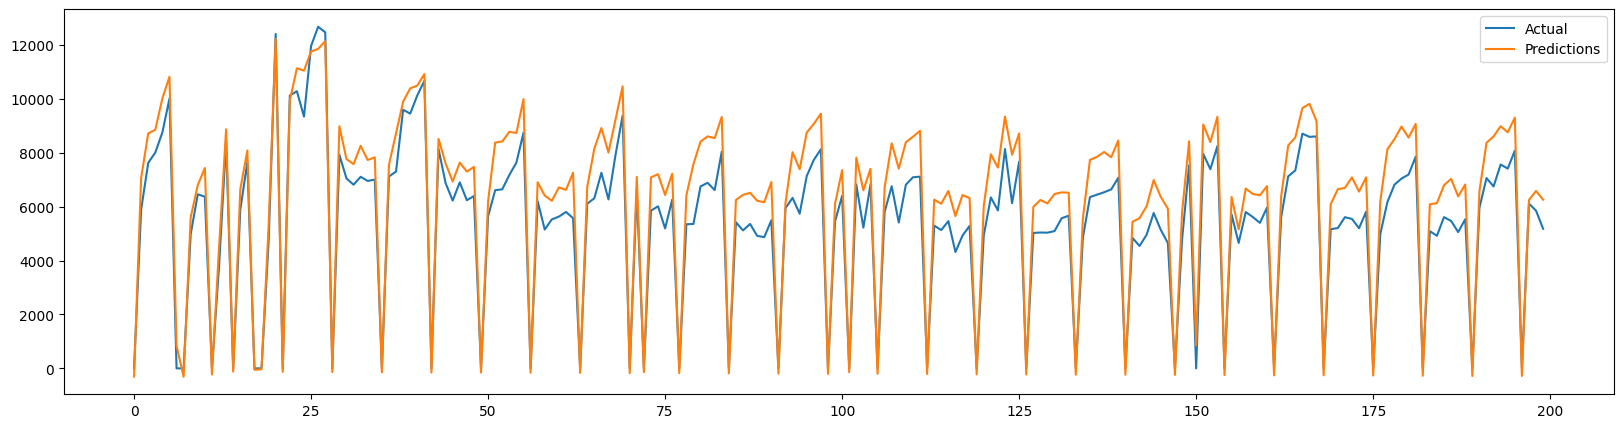

LinearRegression()

In [155]:
from sklearn.linear_model import LinearRegression
# Model building
linear_reg_model=LinearRegression()
print("Linear Regression Model")
model_fit(linear_reg_model)

# Laso Regression to predict sales

Lasso Regression Model


RMSPE : 0.165


   Predictions  Actual
0  -460.350838       0
1  6984.590605    5890
2  8604.904883    7625
3  8748.544861    8010
4  9998.123502    8756




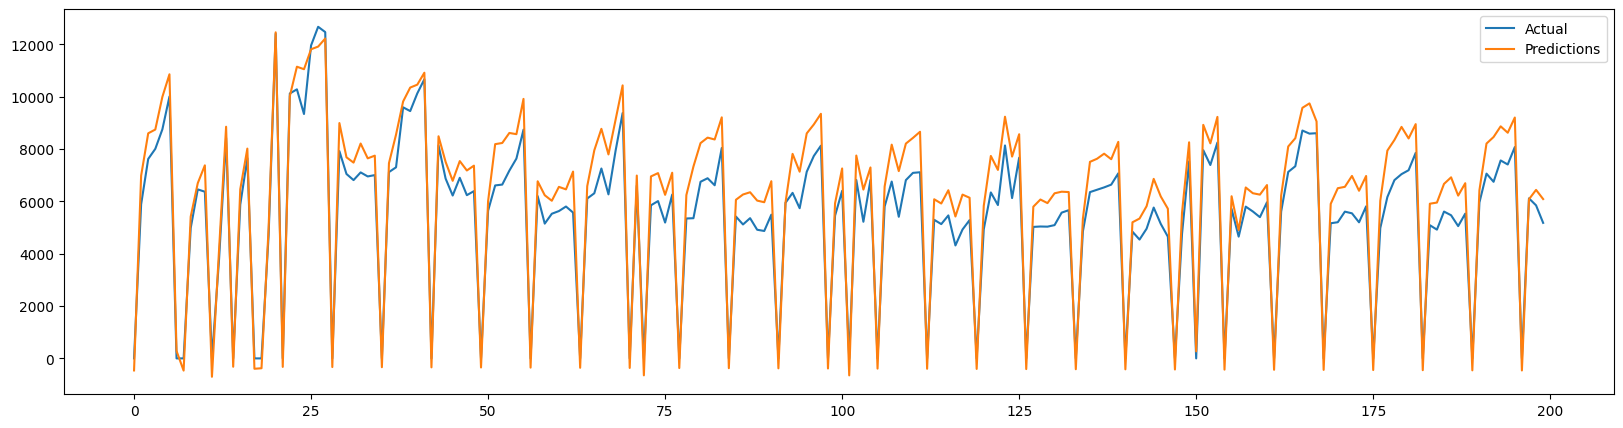

Lasso(alpha=2)

In [94]:
from sklearn.linear_model import Lasso
# Model building
Lasso_reg_model = Lasso(alpha=2)
print("Lasso Regression Model")
model_fit(Lasso_reg_model)

# Decision Tree Regressor

Decision Tree Regressor


RMSPE : 0.205


   Predictions  Actual
0          0.0       0
1       6194.0    5890
2       7197.0    7625
3       7367.0    8010
4       9800.0    8756




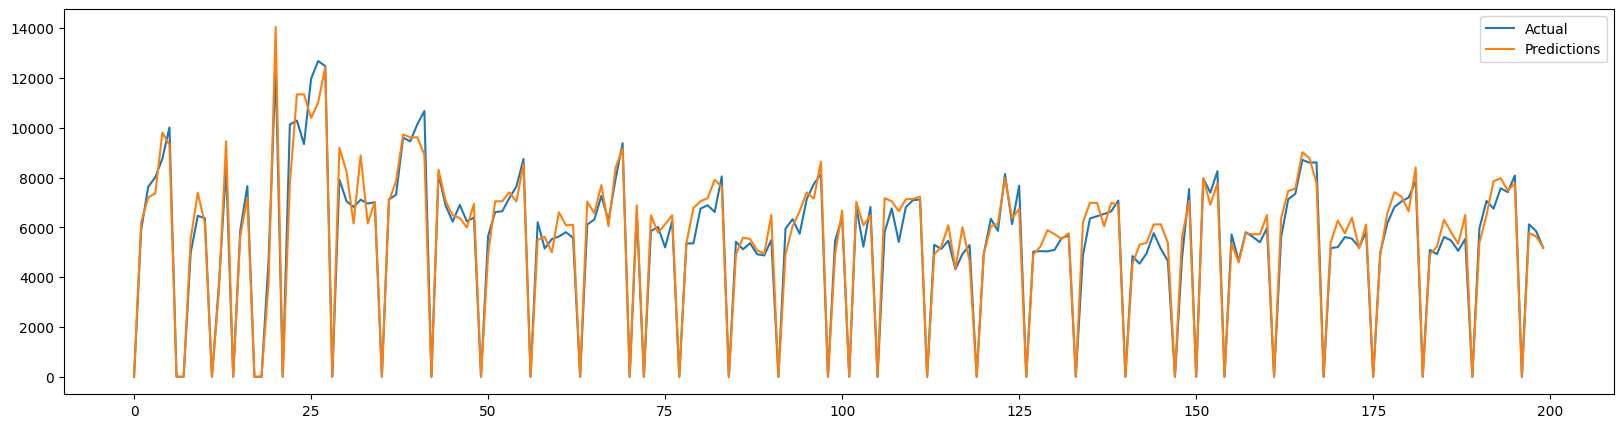

DecisionTreeRegressor(random_state=42)

In [95]:
# Model building
from sklearn.tree import DecisionTreeRegressor
decision_tree_model = DecisionTreeRegressor(random_state=42)
print("Decision Tree Regressor")
model_fit(decision_tree_model)

# Random Forest

Random Forest


RMSPE : 0.174


   Predictions  Actual
0         0.00       0
1      6715.00    5890
2      7605.98    7625
3      7916.95    8010
4      9604.47    8756




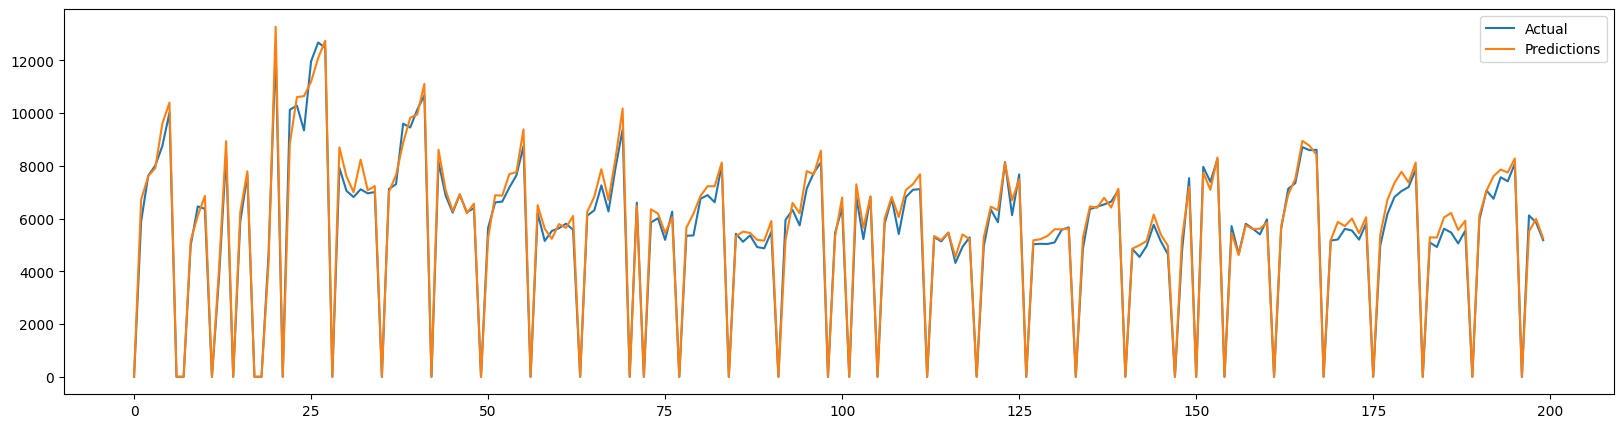

RandomForestRegressor(n_jobs=-1, random_state=42)

In [96]:
# Model building
from sklearn.ensemble import RandomForestRegressor
random_forest_model = RandomForestRegressor(random_state=42,n_jobs=-1)
print("Random Forest")
model_fit(random_forest_model)

# Ridge Regression

Ridge Regression


RMSPE : 0.165


    Predictions  Actual
0   -438.955505       0
1   6983.088449    5890
2   8615.492489    7625
3   8760.999973    8010
4  10011.419837    8756




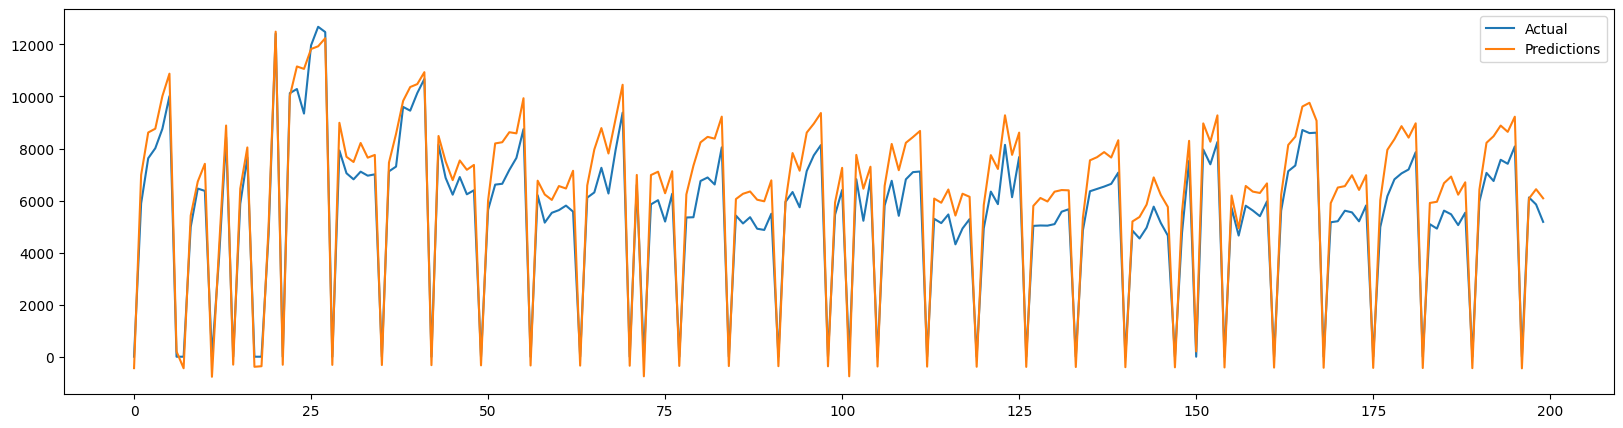

Ridge(alpha=0.1)

In [97]:
from sklearn.linear_model import Ridge
ridge = Ridge(alpha=0.1)
print("Ridge Regression")
model_fit(ridge)


# Feature Importance

<Axes: ylabel='Feature'>

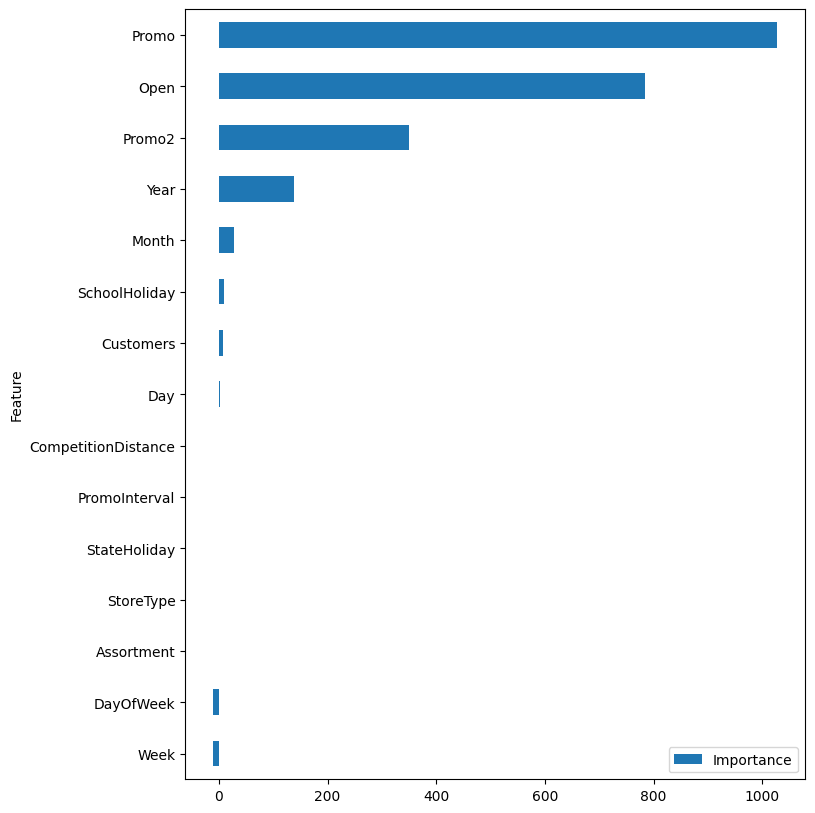

In [156]:
# Linear Regression feature importance

coefficients = linear_reg_model.coef_

#avg_importance = np.mean(np.abs(coefficients), axis=0)
feature_importance = pd.DataFrame({'Feature': X_train.columns, 'Importance': coefficients})
feature_importance = feature_importance.sort_values('Importance', ascending=True)
feature_importance.plot(x='Feature', y='Importance', kind='barh', figsize=(8, 10))

# Conclusion
According to RMSPE result, we found that Linear and Lasso Regression models perform well with 16%.
For feature importance, Promo, Open and Promo2 features play important role for this prediction.